In [1]:
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Input

In [2]:
# (23, 12) Golay code
def golay(data_size):
    m_len = 12

    P = np.array([
        [1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1],
        [1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
        [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1],
        [1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0],
        [0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
        [0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1],
        [1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0],
        [0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0],
        [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1],
        [1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
        [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1],
    ], dtype='int')

    G = np.concatenate((np.eye(m_len, dtype="int"), P), axis=1)

    msg = np.random.randint(0,2, (data_size, m_len))
    codeword = np.dot(msg, G) %2

    return codeword

In [3]:
def Hamming(data_size):
    G = np.array([
        [1, 1, 1, 0, 0 ,0, 0, 1],
        [1, 0 ,0, 1, 1, 0, 0, 1],
        [0, 1, 0, 1, 0, 1, 0, 1],
        [1, 1, 0, 1, 0, 0, 1, 0]
    ], dtype='int')

    msg = np.random.randint(0,2, (data_size, 4))
    codeword = np.dot(msg, G) %2

    return codeword

In [4]:
def BCH(data_size):
    c_length = 15
    m_length = 7
    G_X_15_7 = [1,1,1,0,1,0,0,0,1]

    BCH_15_7_G = np.zeros((7,15))

    for i in range(7):
        BCH_15_7_G[i,i:i+9] = G_X_15_7

    for i in range(7):
        for j in range(i+1,7):
            if BCH_15_7_G[i, j] == 1:
                BCH_15_7_G[i] = (BCH_15_7_G[i] + BCH_15_7_G[j])%2

    G = BCH_15_7_G # G =BCH_7_4_G
    msg = np.random.randint(0,2,(data_size,m_length))
    codeword = np.dot(msg, G)%2

    return codeword

In [5]:
def product(data_size):
    G = np.array([
        [1, 0, 1, 0, 0 ,0, 1, 0],
        [0, 1 ,1, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 1, 1, 0],
        [0, 0, 0, 1, 1, 1, 0, 1]
    ], dtype='int')

    msg = np.random.randint(0,2, (data_size, 4))
    codeword = np.dot(msg, G) %2

    return codeword

In [6]:
def make_F(power):
    F = np.array([[1,0],[1,1]])
    for i in range(1,power):
        first = np.concatenate((F,np.zeros((2**i, 2**i))), axis=1)
        second = np.concatenate((F,F), axis=1)
        F = np.concatenate((first, second), axis =0)

    return F
def Compute_z(z, k, i = 1):
    for j in range(i):
        z[(2*i,2*j)] = 2*z[(i,j)] - (z[(i,j)])**2
        z[(2*i,2*j+1)] = (z[(i,j)])**2
    if 2*i < 2**k:
        z = Compute_z(z, k, 2*i)

    return z
def Frozen_bits(n, z, slice_index):
    bit_index = np.zeros(n)
    for i in range(n):
        bit_index[i] = z[(n, i)]

    bit_index = np.argsort(bit_index)[::-1]

    frozen_bit_index = bit_index[:slice_index]
    message_bit_index = bit_index[slice_index:]
    
    return np.sort(frozen_bit_index), np.sort(message_bit_index)

def polar(data_size):
    # (n, k) Polar code
    k = 4
    n = 2*k
    power = int(np.log2(n))

    F = make_F(power)

    z = {}
    z[(1,0)] = 0.5
    z = Compute_z(z, power)

    frozen_bit_index, message_bit_index = Frozen_bits(n, z, int(n-k))

    msg = np.random.randint(0,2,(data_size, k))
    u = np.zeros((data_size, n))
    u[:,message_bit_index] = msg

    codeword = np.dot(u,F)%2

    return codeword

In [7]:
def G_matrix(length, m, r):
    G = np.ones(length)
    for i in range(m):
        v = np.zeros((int(length/(2**(i+1)))))
        v = np.hstack((v, np.ones((int(length/(2**(i+1)))))))
        while v.shape[0] < length :
            v = np.hstack((v, np.zeros((int(length/(2**(i+1)))))))
            v = np.hstack((v, np.ones((int(length/(2**(i+1)))))))
        G = np.vstack((G,v))
    if r == 1:
        return G
    elif r > 1 :
        for i in range(1,m):
            for j in range(i+1,m+1):
                G = np.vstack((G,(G[i]*G[j])))
        if r == 3:
            G = np.vstack((G,(G[1]*G[2]*G[3])))
            G = np.vstack((G,(G[1]*G[3]*G[4])))
            G = np.vstack((G,(G[1]*G[2]*G[4])))
            G = np.vstack((G,(G[2]*G[3]*G[4])))
        return G
    return G

def rm(data_size):
    m = 4
    r = 2
    length = 2**m

    if r == 1:
        masking_length=0
        msg_length = m+r
    elif r == 2:
        masking_length=6
        msg_length = 11
    elif r == 3:
        masking_length=10
        msg_length = 15

    G = G_matrix(length, m, r)
    msg = np.random.randint(0,2,(data_size,msg_length))
    codeword = np.dot(msg, G) %2

    return codeword

In [8]:
class Convolutional_code():
    def __init__(self, case):
        if case == 1:  # C(2,1,3) [5,7] (101, 111)
            self.m_num = 2
            self.g_func = np.array([[False,True],[True,True]])
            self.code_rate = 1/2

        elif case == 2:  # C(2,1,4) [13,17] (1011, 1111)
            self.m_num = 3
            self.g_func = np.array([[False,True,True],[True,True,True]])
            self.code_rate = 1/2

        elif case == 3:  # C(2,1,5) [27,31] (10111, 11001)
            self.m_num = 4
            self.g_func = np.array([[False,True,True,True],[True,False, False,True]])
            self.code_rate = 1/2

    def encoder(self,data_size, m = None):
        datas = np.random.randint(0,2,(data_size))
        if m is None:
            m = np.zeros(self.m_num)
            datas = np.hstack((datas,m))

        result = []
        tr_m = np.array(m)

        for data in datas:
            for j in range(tr_m[self.g_func[0]].shape[0]):
                if j == 0:
                    result_1 = (tr_m[self.g_func[0]][j]+data) % 2
                else:
                    result_1 = (tr_m[self.g_func[0]][j]+result_1) % 2

            for j in range(tr_m[self.g_func[1]].shape[0]):
                if j == 0:
                    result_2 = (tr_m[self.g_func[1]][j]+data) % 2
                else:
                    result_2 = (tr_m[self.g_func[1]][j]+result_2) % 2

            result.extend([result_1, result_2])

            tr_m = np.roll(tr_m, 1)
            tr_m[0] = data
        
        return np.array(result), tr_m

In [9]:
def AWGN(ebno, code_rate, data):
    dB = 10**(ebno/10)
    sigma = np.sqrt(1/(2*code_rate*dB))
    noise_i = sigma * np.random.randn(data.shape[0], data.shape[1], data.shape[2], data.shape[3])
    noise_q = sigma * np.random.randn(data.shape[0], data.shape[1], data.shape[2], data.shape[3])

    noise_data = data + noise_i + 1j*noise_q

    return noise_data

In [10]:
def VGG_19(weights_path=None):
    first_layer = Input(shape=(128,128, 1))
    model = Sequential()
    model.add(first_layer)
    model.add(Convolution2D(64, (3, 3), activation='relu', padding= 'same'))
    model.add(Convolution2D(64, (3, 3), activation='relu', padding= 'same'))
    model.add(MaxPooling2D((2,2), strides=(2,2))) # 64

    model.add(Convolution2D(128, (3, 3), activation='relu', padding= 'same'))
    model.add(Convolution2D(128, (3, 3), activation='relu', padding= 'same'))
    model.add(MaxPooling2D((2,2), strides=(2,2))) # 32

    model.add(Convolution2D(256, (3, 3), activation='relu', padding= 'same'))
    model.add(Convolution2D(256, (3, 3), activation='relu', padding= 'same'))
    model.add(MaxPooling2D((2,2), strides=(2,2))) # 16
 
    model.add(Convolution2D(512, (3, 3), activation='relu', padding= 'same'))
    model.add(Convolution2D(512, (3, 3), activation='relu', padding= 'same'))
    model.add(Convolution2D(512, (3, 3), activation='relu', padding= 'same'))
    model.add(Convolution2D(512, (3, 3), activation='relu', padding= 'same'))
    model.add(MaxPooling2D((2,2), strides=(2,2))) # 8

    model.add(Convolution2D(512, (3, 3), activation='relu', padding= 'same'))
    model.add(Convolution2D(512, (3, 3), activation='relu', padding= 'same'))
    model.add(Convolution2D(512, (3, 3), activation='relu', padding= 'same'))
    model.add(Convolution2D(512, (3, 3), activation='relu', padding= 'same'))
    model.add(MaxPooling2D((2,2), strides=(2,2))) # 4

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))
    
    if weights_path:
        model.load_weights(weights_path)
    
    return model

In [11]:
vgg = VGG_19()
vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
def generate_codeword(size):
    conv = Convolutional_code(3)
    conv_c,_ = conv.encoder(int(np.ceil(128*128*size/2))) # 1
    conv_c = np.reshape(conv_c[:(128*128)*size],(-1,128,128,1))

    bch_c = BCH(int(np.ceil(128*128*size/15))) # 2
    bch_c = bch_c.flatten()
    bch_c = np.reshape(bch_c[:(128*128)*size],(-1,128,128,1))

    polar_c = polar(int(np.ceil(128*128*size/8))) # 3
    polar_c = polar_c.flatten()
    polar_c = np.reshape(polar_c[:(128*128)*size],(-1,128,128,1))

    hamming_c = Hamming(int(np.ceil(128*128*size/8))) # 4
    hamming_c = hamming_c.flatten()
    hamming_c = np.reshape(hamming_c[:(128*128)*size],(-1,128,128,1))

    product_c = product(int(np.ceil(128*128*size/8))) # 5
    product_c = product_c.flatten()
    product_c = np.reshape(product_c[:(128*128)*size],(-1,128,128,1))

    rm_c = rm(int(np.ceil(128*128*size/16))) # 6
    rm_c = rm_c.flatten()
    rm_c = np.reshape(rm_c[:(128*128)*size],(-1,128,128,1))

    golay_c = golay(int(np.ceil(128*128*size/23))) # 7
    golay_c = golay_c.flatten()
    golay_c = np.reshape(golay_c[:(128*128)*size],(-1,128,128,1))

    return (-1)**conv_c, (-1)**bch_c, (-1)**polar_c, (-1)**hamming_c, (-1)**product_c, (-1)**rm_c, (-1)**golay_c

In [13]:
conv_x = []
bch_x = []
polar_x = []
hamming_x = []
product_x = []
rm_x = []
golay_x = []

for ebno in range(-5, 21):
    
    conv_c, bch_c, polar_c, hamming_c, product_c, rm_c, golay_c = generate_codeword(1000)

    conv_r = np.where(AWGN(ebno, 0.5, conv_c) > 0, 0, 1)
    bch_r = np.where(AWGN(ebno, 7/15, bch_c) > 0, 0, 1)
    polar_r = np.where(AWGN(ebno, 0.5, polar_c) > 0, 0, 1)
    hamming_r = np.where(AWGN(ebno, 0.5, hamming_c) > 0, 0, 1)
    product_r = np.where(AWGN(ebno, 0.5, product_c) > 0, 0, 1)
    rm_r = np.where(AWGN(ebno, 11/16, rm_c) > 0, 0, 1)
    golay_r = np.where(AWGN(ebno, 12/23, golay_c) > 0, 0, 1)

    conv_x.extend(conv_r)
    bch_x.extend(bch_r)
    polar_x.extend(polar_r)
    hamming_x.extend(hamming_r)
    product_x.extend(product_r)
    rm_x.extend(rm_r)
    golay_x.extend(golay_r)

In [14]:
train_x = conv_x+bch_x+polar_x+hamming_x+product_x+rm_x+golay_x
train_label = [0]*len(conv_x) + [1]*len(bch_x) + [2]*len(polar_x) + [3]*len(hamming_x) +\
            [4]*len(product_x) + [5]*len(rm_x) + [6]*len(golay_x)

In [15]:
train_x = np.array(train_x)
train_label = np.array(train_label)

In [16]:
vgg.fit(train_x, train_label, epochs=100, batch_size=100, shuffle=True)

Epoch 1/100
1820/1820 [==============================] - 410s 220ms/step - loss: 1.9463 - accuracy: 0.1430
Epoch 2/100
1820/1820 [==============================] - 406s 223ms/step - loss: 1.9460 - accuracy: 0.1424
Epoch 3/100
1820/1820 [==============================] - 407s 224ms/step - loss: 1.9460 - accuracy: 0.1430
Epoch 4/100
1820/1820 [==============================] - 409s 225ms/step - loss: 1.9460 - accuracy: 0.1436
Epoch 5/100
1820/1820 [==============================] - 408s 224ms/step - loss: 1.9460 - accuracy: 0.1422
Epoch 6/100
1820/1820 [==============================] - 408s 224ms/step - loss: 1.9460 - accuracy: 0.1420
Epoch 7/100
1820/1820 [==============================] - 408s 224ms/step - loss: 1.9460 - accuracy: 0.1436
Epoch 8/100
1820/1820 [==============================] - 409s 225ms/step - loss: 1.9460 - accuracy: 0.1430
Epoch 9/100
1820/1820 [==============================] - 409s 225ms/step - loss: 1.9460 - accuracy: 0.1408
Epoch 10/100
1820/1820 [=============

In [17]:
vgg.save('model.h5')

In [32]:
accs = []
for ebno in range(-5, 21):
    print(ebno)
    conv_x = []
    bch_x = []
    polar_x = []
    hamming_x = []
    product_x = []
    rm_x = []
    golay_x = []
    
    conv_c, bch_c, polar_c, hamming_c, product_c, rm_c, golay_c = generate_codeword(100)

    conv_r = np.where(AWGN(ebno, 0.5, conv_c) > 0, 0, 1)
    bch_r = np.where(AWGN(ebno, 7/15, bch_c) > 0, 0, 1)
    polar_r = np.where(AWGN(ebno, 0.5, polar_c) > 0, 0, 1)
    hamming_r = np.where(AWGN(ebno, 0.5, hamming_c) > 0, 0, 1)
    product_r = np.where(AWGN(ebno, 0.5, product_c) > 0, 0, 1)
    rm_r = np.where(AWGN(ebno, 11/16, rm_c) > 0, 0, 1)
    golay_r = np.where(AWGN(ebno, 12/23, golay_c) > 0, 0, 1)

    conv_x.extend(conv_r)
    bch_x.extend(bch_r)
    polar_x.extend(polar_r)
    hamming_x.extend(hamming_r)
    product_x.extend(product_r)
    rm_x.extend(rm_r)
    golay_x.extend(golay_r)

    test_x = conv_x+bch_x+polar_x+hamming_x+product_x+rm_x+golay_x
    test_label = [0]*len(conv_r) + [1]*len(bch_r) + [2]*len(polar_r) + [3]*len(hamming_r) +\
                [4]*len(product_r) + [5]*len(rm_r) + [6]*len(golay_r)
    
    test_x = np.array(test_x)
    test_label = np.array(test_label)

    _, acc = vgg.evaluate(test_x, test_label, verbose=0)

    accs.append(acc)

-5
-4
-3
-2
-1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [33]:
import matplotlib.pyplot as plt


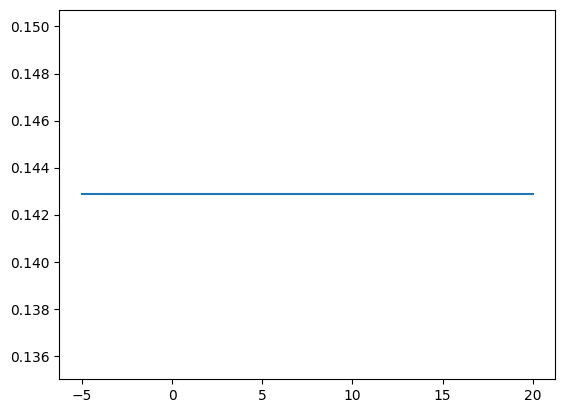

In [34]:
x = np.arange(-5,21)
plt.plot(x, accs)

conv 0
[[0.14613798 0.14335553 0.14481528 0.14163196 0.14100271 0.14239147
  0.14066502]]


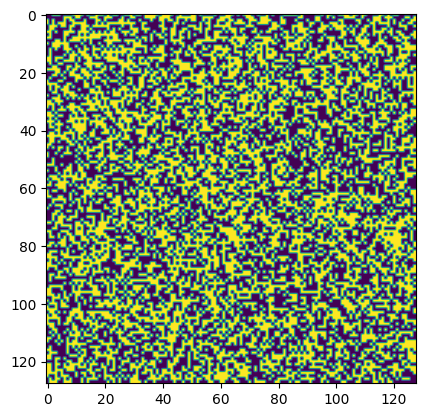

conv 1
[[0.14613798 0.14335553 0.14481528 0.14163196 0.14100271 0.14239147
  0.14066502]]


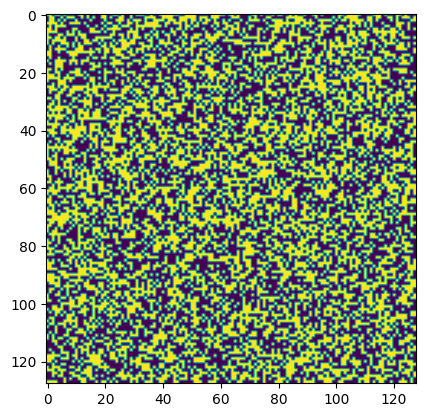

In [74]:
print('conv 0')
result = vgg.predict(np.array(conv_x[0:1]), verbose=0)
print(result)

plt.imshow(conv_x[0])
plt.show()

print('conv 1')
result = vgg.predict(np.array(conv_x[1:2]), verbose=0)
print(result)

plt.imshow(conv_x[1])
plt.show()

[[0.14613798 0.14335553 0.14481528 0.14163196 0.14100271 0.14239147
  0.14066502]]


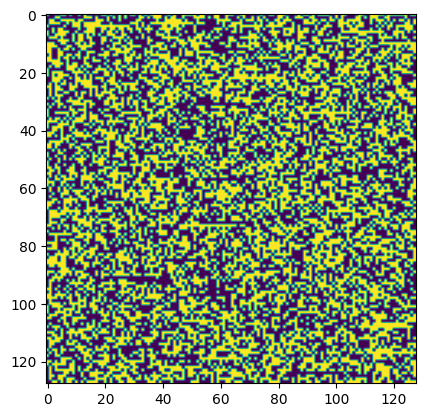

[[0.14613798 0.14335553 0.14481528 0.14163196 0.14100271 0.14239147
  0.14066502]]


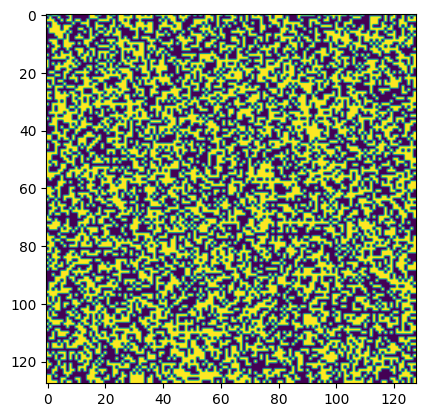

In [75]:
result = vgg.predict(np.array(bch_x[0:1]), verbose=0)
print(result)

plt.imshow(bch_x[0])
plt.show()

result = vgg.predict(np.array(bch_x[1:2]), verbose=0)
print(result)

plt.imshow(bch_x[1])
plt.show()